In [ ]:
!pip install lightgbm==3.3.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.6.0
    Uninstalling lightgbm-4.6.0:
      Successfully uninstalled lightgbm-4.6.0


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import xgboost as xgb
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [2]:
df_txn=pd.read_csv("drive/MyDrive/data/acct_transaction.csv")
df_alert=pd.read_csv("drive/MyDrive/data/acct_alert.csv")
df_predict=pd.read_csv("drive/MyDrive/data/acct_predict.csv")

In [3]:
df_txn["is_self_txn"] = pd.to_numeric(df_txn["is_self_txn"], errors="coerce")
df_txn["channel_type"] = df_txn["channel_type"].astype("category").cat.codes

df_txn["currency_type"] = pd.to_numeric(df_txn["currency_type"], errors="coerce")

In [22]:
df_txn['txn_time'] = pd.to_datetime(df_txn['txn_time'])
df_txn['txn_date'] = df_txn['txn_time'].dt.date
df_txn['daily_txn_count'] = df_txn.groupby(['from_acct', 'txn_date'])['txn_amt'].transform('count')
df_txn['same_time_txn_count'] = df_txn.groupby(['from_acct', 'txn_time'])['txn_amt'].transform('count')
df_txn['txn_hour'] = df_txn['txn_time'].dt.hour
df_txn['time_block'] = pd.cut(df_txn['txn_hour'], bins=[0,8,16,24], labels=['morning','afternoon','night'])
df_txn['amt_level'] = pd.cut(df_txn['txn_amt'], bins=[0,1000,10000,float('inf')], labels=['small','medium','large'])
feat_from = df_txn.groupby("from_acct").agg(
    mean_is_self=("is_self_txn","mean"),
    unique_channel=("channel_type", "nunique"),
    unique_currency=("currency_type", "nunique"),
    max_same_time_txn=('same_time_txn_count', 'max'),
    mean_same_time_txn=('same_time_txn_count', 'mean'),
    max_same_day_txn=('daily_txn_count', 'max'),
    mean_same_day_txn=('daily_txn_count', 'mean'),
    from_txn_count=("txn_amt", "count"),
    from_amt_sum=("txn_amt", "sum"),
    from_amt_mean=("txn_amt", "mean"),
    from_amt_max=("txn_amt", "max"),
    from_amt_min=("txn_amt", "min"),
    unique_to_acct=("to_acct", "nunique"),

    # morning_txn_count_f=("time_block", lambda x: (x=='morning').sum()),
    # afternoon_txn_count=("time_block", lambda x: (x=='afternoon').sum()),
    # night_txn_count=("time_block", lambda x: (x=='night').sum()),

    # small_txn_count=("amt_level", lambda x: (x=='small').sum()),
    # medium_txn_count=("amt_level", lambda x: (x=='medium').sum()),
    # large_txn_count=("amt_level", lambda x: (x=='large').sum())

).reset_index().rename(columns={"from_acct": "acct"})
feat_to = df_txn.groupby("to_acct").agg(
    mean_is_self=("is_self_txn","mean"),
    unique_channel=("channel_type", "nunique"),
    unique_currency=("currency_type", "nunique"),
    max_same_time_txn=('same_time_txn_count', 'max'),
    mean_same_time_txn=('same_time_txn_count', 'mean'),
    max_same_day_txn=('daily_txn_count', 'max'),
    mean_same_day_txn=('daily_txn_count', 'mean'),
    to_txn_count=("txn_amt", "count"),
    to_amt_sum=("txn_amt", "sum"),
    to_amt_mean=("txn_amt", "mean"),
    to_amt_max=("txn_amt", "max"),
    to_amt_min=("txn_amt", "min"),
    unique_from_acct=("from_acct", "nunique"),

    # morning_txn_count=("time_block", lambda x: (x=='morning').sum()),
    # afternoon_txn_count=("time_block", lambda x: (x=='afternoon').sum()),
    # night_txn_count=("time_block", lambda x: (x=='night').sum()),

    # small_txn_count=("amt_level", lambda x: (x=='small').sum()),
    # medium_txn_count=("amt_level", lambda x: (x=='medium').sum()),
    # large_txn_count=("amt_level", lambda x: (x=='large').sum())

).reset_index().rename(columns={"to_acct": "acct"})
feat_all = pd.merge(feat_from, feat_to, on="acct", how="outer").fillna(0)


In [23]:
df_alert["label"] = 1
train_df = feat_all.merge(df_alert[["acct", "label"]], on="acct", how="left")
train_df["label"] = train_df["label"].fillna(0)


In [24]:
X = train_df.drop(columns=["label", "acct"])
y = train_df["label"]

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
for col in X_train.columns:
    if X_train[col].dtype.name == 'category' or X_train[col].nunique() < 20:
        X_train[col].fillna(X_train[col].mode()[0], inplace=True)
        X_val[col].fillna(X_train[col].mode()[0], inplace=True)
    else:
        X_train[col].fillna(X_train[col].median(), inplace=True)
        X_val[col].fillna(X_train[col].median(), inplace=True)

使用XGBoost

In [37]:
xgb_model = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=7,
    eval_metric="logloss",
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),
    use_label_encoder=False,
    early_stopping_rounds=50,
    random_state=42
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],


    verbose=True
)


[0]	validation_0-logloss:0.68177
[1]	validation_0-logloss:0.67086
[2]	validation_0-logloss:0.66033
[3]	validation_0-logloss:0.65030


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [05:59:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[4]	validation_0-logloss:0.64055
[5]	validation_0-logloss:0.63117
[6]	validation_0-logloss:0.62220
[7]	validation_0-logloss:0.61353
[8]	validation_0-logloss:0.60515
[9]	validation_0-logloss:0.59716
[10]	validation_0-logloss:0.58939
[11]	validation_0-logloss:0.58195
[12]	validation_0-logloss:0.57476
[13]	validation_0-logloss:0.56783
[14]	validation_0-logloss:0.56104
[15]	validation_0-logloss:0.55447
[16]	validation_0-logloss:0.54816
[17]	validation_0-logloss:0.54212
[18]	validation_0-logloss:0.53628
[19]	validation_0-logloss:0.53055
[20]	validation_0-logloss:0.52501
[21]	validation_0-logloss:0.51961
[22]	validation_0-logloss:0.51443
[23]	validation_0-logloss:0.50937
[24]	validation_0-logloss:0.50445
[25]	validation_0-logloss:0.49956
[26]	validation_0-logloss:0.49500
[27]	validation_0-logloss:0.49046
[28]	validation_0-logloss:0.48597
[29]	validation_0-logloss:0.48154
[30]	validation_0-logloss:0.47743
[31]	validation_0-logloss:0.47337
[32]	validation_0-logloss:0.46926
[33]	validation_0-lo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1500, n_jobs=None,
              num_parallel_tree=None, ...)

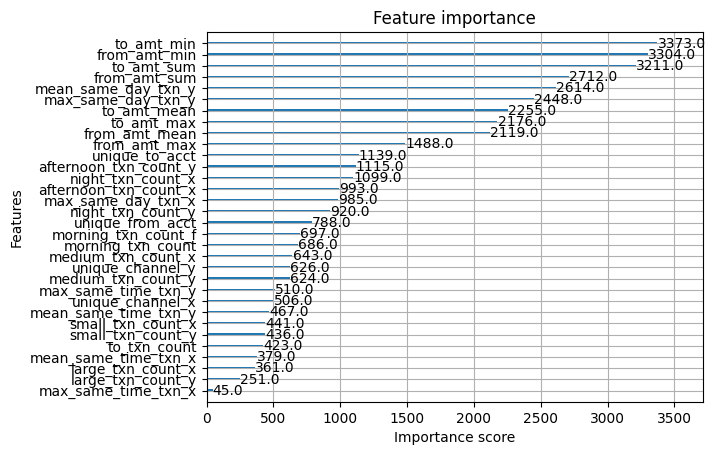

In [20]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(xgb_model, max_num_features=50)
plt.show()


In [38]:
y_val_proba = xgb_model.predict_proba(X_val)[:,1]
best_f1 = 0
best_thresh = 0.5
for t in np.arange(0.1, 0.999, 0.001):
    f1 = f1_score(y_val, (y_val_proba > t).astype(int))
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print(f"Best Threshold: {best_thresh:.3f}, Validation F1: {best_f1:.4f}")

Best Threshold: 0.978, Validation F1: 0.1472


In [28]:
y_pred_val = (xgb_model.predict(X_val) > best_thresh).astype(int)
print("Validation F1:", f1_score(y_val, y_pred_val))

Validation F1: 0.024077466631771786


預測資料


In [29]:
pred_feat = feat_all.copy()
pred_feat = df_predict.merge(pred_feat, on="acct", how="left")

In [30]:
pred_feat = pred_feat.fillna(0)

X_test = pred_feat.drop(columns=["acct", "from_acct", "label"], errors="ignore")

In [31]:
pred_feat["label"] = (xgb_model.predict(X_test) > best_thresh).astype(int)

In [32]:
submission = pred_feat[["acct", "label"]]
submission.to_csv("submission.csv", index=False)
print("✅ 輸出完成：submission.csv 已建立")

✅ 輸出完成：submission.csv 已建立
